# IMPROVE IMDB model
With 25k example, model achieved ~99% accuracy on train set, and ~88% accuracy on val set.

This note book try to improve accuracy on val set by
* Use MLP with TF IDF, which try to keep information as much as possible
* LSTM, with only top 10 word excluded ( instead of stopwords.words("english") ) 
* TF IDF + LSTM


In [3]:
import os
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import keras
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif
from keras.layers import Embedding, Bidirectional, GlobalMaxPool1D, Dense, Dropout, LSTM
from keras.models import Model, Sequential

In [5]:
imdb = keras.datasets.imdb
(input_train_data, input_train_labels), (input_test_data, input_test_labels) = imdb.load_data()
word_index = imdb.get_word_index()
vocaburary_size = len(word_index)
print("train set size is ", input_train_data.shape)
print("vocaburary size is ", vocaburary_size)

train set size is  (25000,)
vocaburary size is  88584


In [125]:
def decode_review(text, dictionary):
    return ' '.join([dictionary[i] for i in text])

def decode_all(input_data, dictionary):
    decode_list = []
    for i in range(input_data.shape[0]):
        decode_ = decode_review(input_data[i], dictionary)
        decode_list.append(decode_.lower())
    return decode_list

def reverse_dictionary(word_index):
    """ Dictionary is reversed, and do not include first 4 word index"""
    word_index = {k: (v+3) for k, v in word_index.items()}
    word_index["<pad>"] = 0
    word_index["<start>"] = 1
    word_index["<unk>"] = 2 #unknow
    word_index["<unused>"] = 3
    reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])
    return reverse_word_index

reverse_word_index =  reverse_dictionary(word_index)
vocaburary_size = len(reverse_word_index)

print("vocaburary size is ", vocaburary_size)
print(decode_review(input_train_data[10], reverse_word_index))

vocaburary size is  88588
<start> french horror cinema has seen something of a revival over the last couple of years with great films such as inside and switchblade romance bursting on to the scene maléfique preceded the revival just slightly but stands head and shoulders over most modern horror titles and is surely one of the best french horror films ever made maléfique was obviously shot on a low budget but this is made up for in far more ways than one by the originality of the film and this in turn is complimented by the excellent writing and acting that ensure the film is a winner the plot focuses on two main ideas prison and black magic the central character is a man named carrère sent to prison for fraud he is put in a cell with three others the quietly insane lassalle body building transvestite marcus and his retarded boyfriend daisy after a short while in the cell together they stumble upon a hiding place in the wall that contains an old journal after translating part of it the

### SHOW TRAIN DATA LENGTH HISTOGRAM

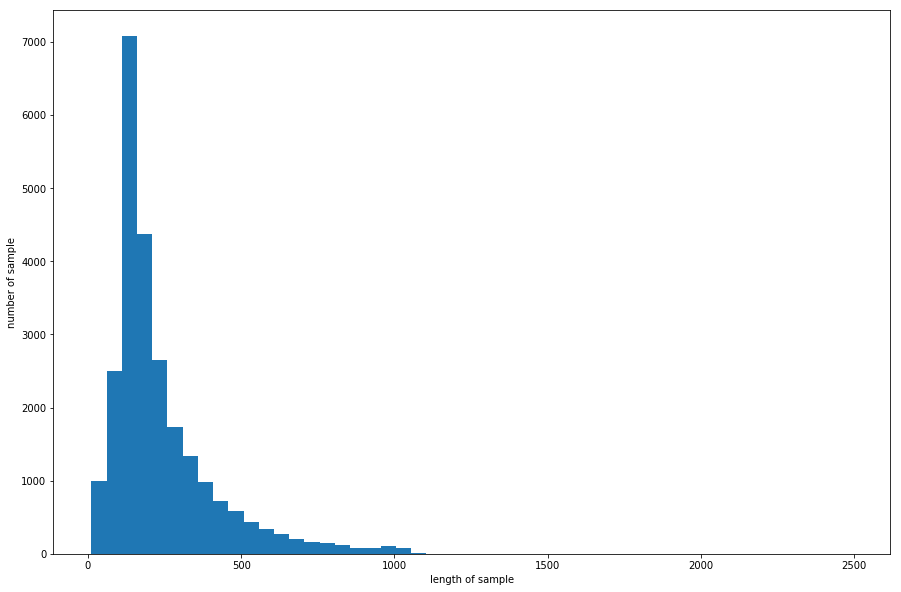

In [122]:
plt.figure(figsize=(15,10))
plt.hist([len(sample) for sample in input_train_data], 50)
plt.xlabel('length of sample')
plt.ylabel('number of sample')
plt.show()

### SHOW TOP 50 WORDS

In [147]:
def get_top_frequently_words(countWord, input_data, dictionary):
    input_data_train_decode = decode_all(input_data, dictionary)
    vectorizer = CountVectorizer()
    input_train_data_vector = vectorizer.fit_transform(input_data_train_decode)
    all_words = vectorizer.get_feature_names()
    all_counts = input_train_data_vector.sum(axis=0).tolist()[0]
    all_words, all_counts = zip(*[(n, c) for c, n in sorted(zip(all_counts, all_words), reverse=True)])
    ngrams = all_words[:countWord]
    counts = all_counts[:countWord]
    return ngrams, counts

('the', 'and', 'of', 'to', 'is', 'br', 'it', 'in', 'this', 'that', 'was', 'as', 'for', 'with', 'movie', 'but', 'film', 'you', 'on', 'not', 'he', 'are', 'his', 'have', 'be', 'one', 'start', 'all', 'at', 'they', 'by', 'an', 'who', 'so', 'from', 'like', 'there', 'her', 'or', 'just', 'about', 'out', 'if', 'has', 'what', 'some', 'good', 'can', 'more', 'she')
(336758, 164141, 145865, 135724, 107336, 101871, 96471, 93978, 76007, 73287, 48209, 46936, 44345, 44130, 44047, 42623, 40161, 34268, 34203, 30634, 30155, 29438, 29376, 27732, 26957, 26795, 26700, 23985, 23516, 22916, 22549, 21564, 21441, 20616, 20499, 20281, 18866, 18424, 18007, 17774, 17375, 17113, 16809, 16791, 16169, 15749, 15147, 14678, 14253, 14228)


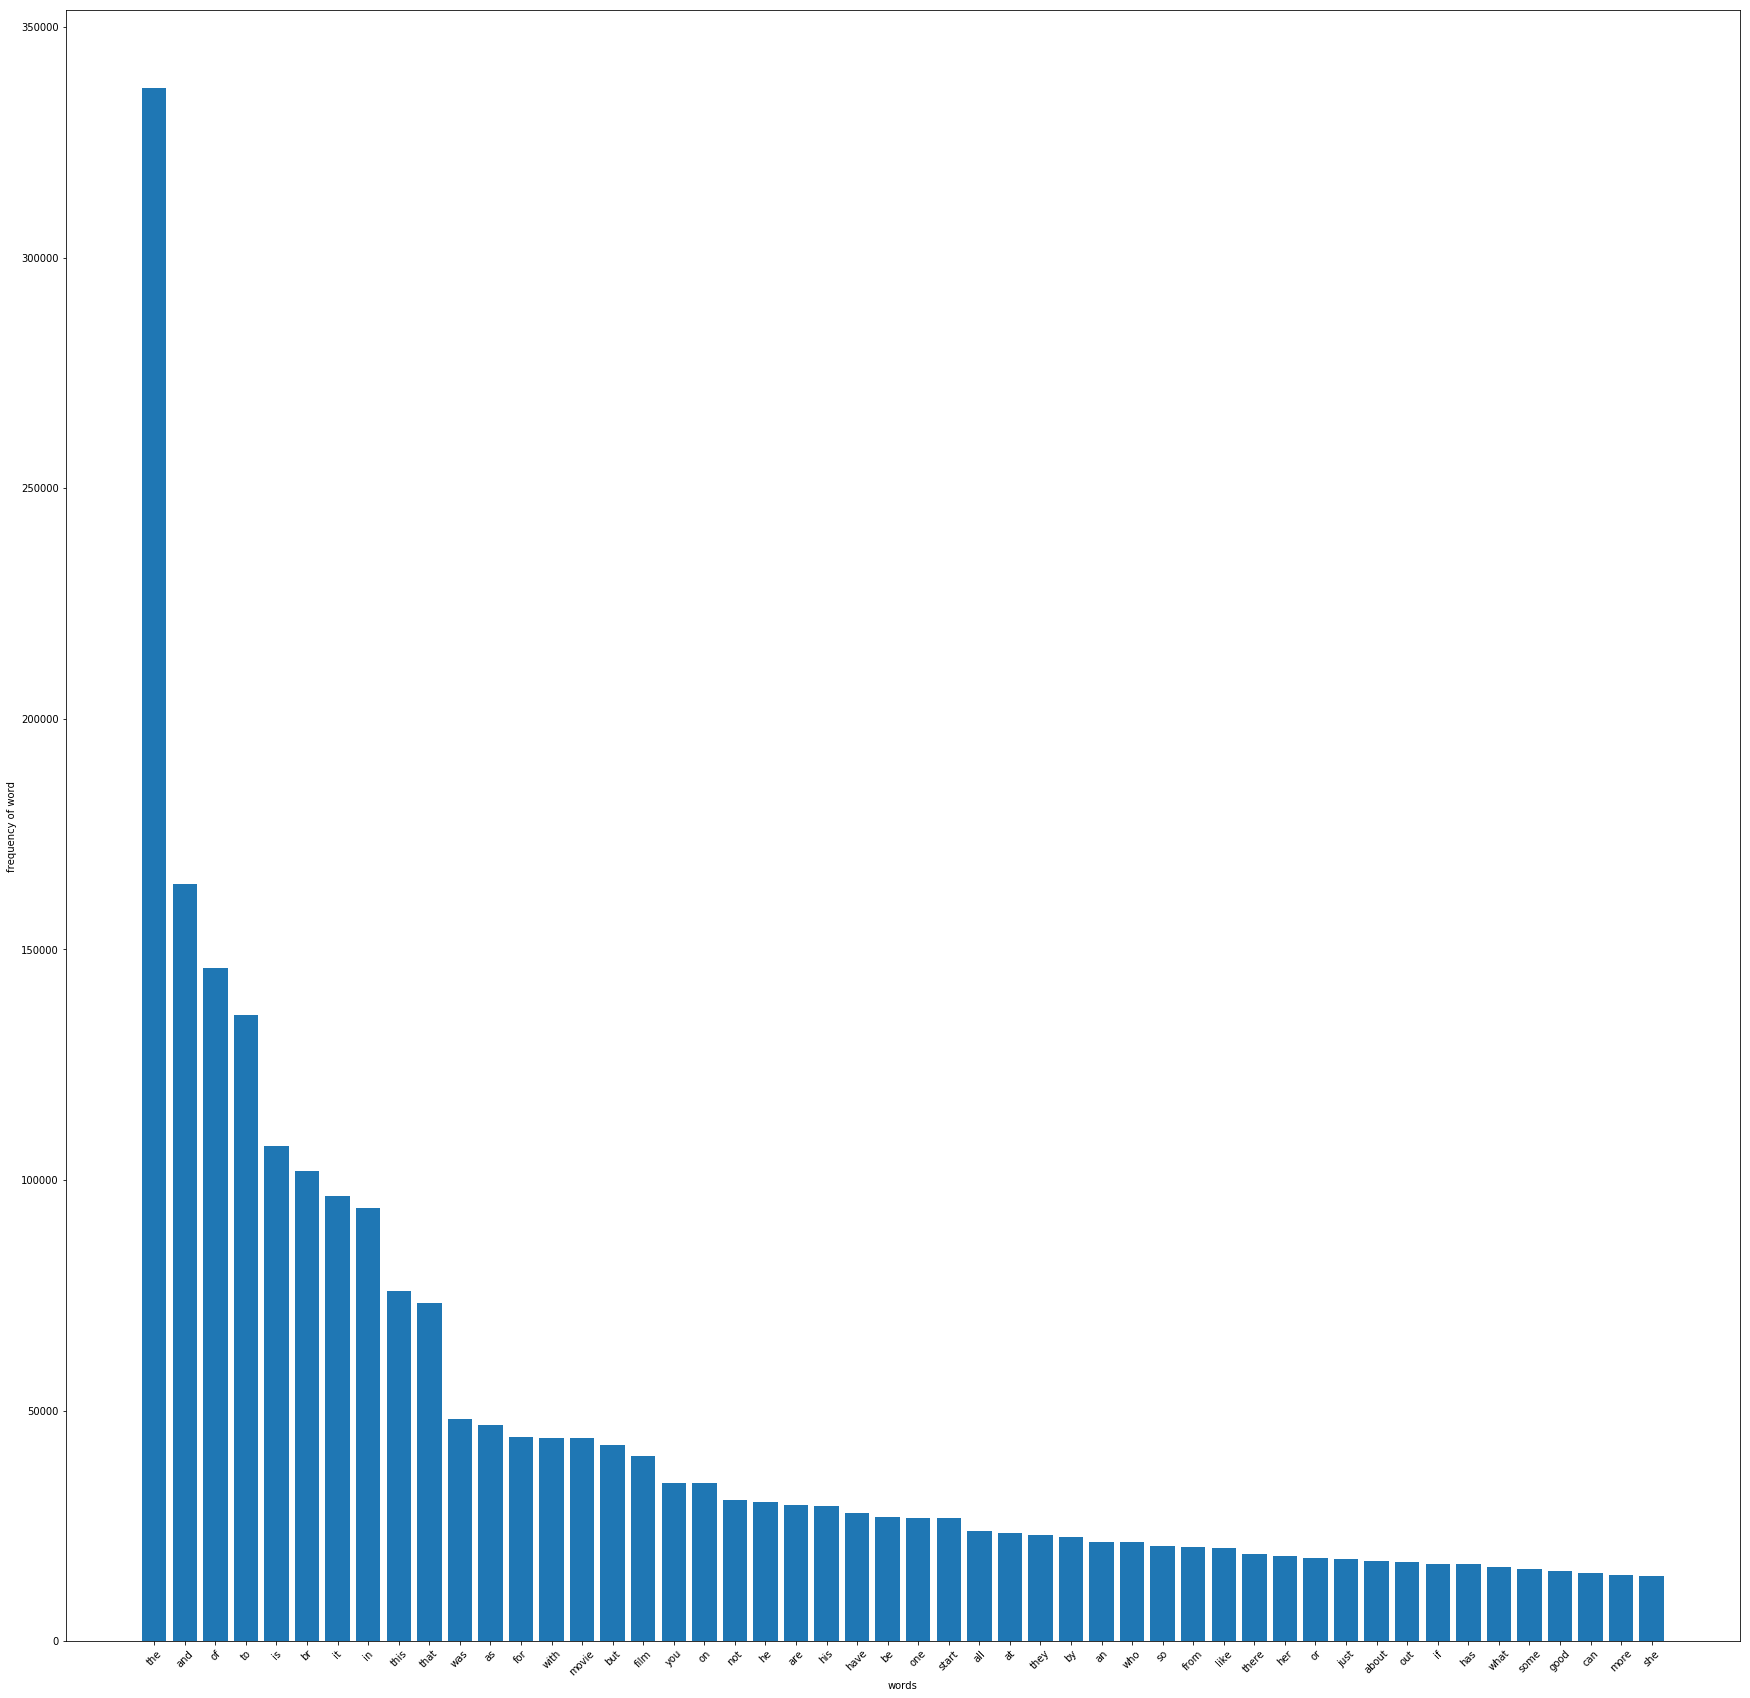

In [148]:
ngrams, counts = get_top_frequently_words(50, input_train_data, reverse_word_index)
idx = np.arange(50)
print(ngrams)
print(counts)
plt.figure(figsize=(30, 30))
plt.bar(idx, counts, 0.8)
plt.xlabel('words')
plt.ylabel('frequency of word')
plt.xticks(idx, ngrams, rotation=45)
plt.show()

In [133]:
def plot_history_loss(fit, axL):
    # Plot the loss in the history
    axL.plot(fit.history['loss'],label="loss for training")
    axL.plot(fit.history['val_loss'],label="loss for validation")
    axL.set_title('model loss')
    axL.set_xlabel('epoch')
    axL.set_ylabel('loss')
    axL.legend(loc='upper right')

# acc
def plot_history_acc(fit, axR):
    # Plot the loss in the history
    axR.plot(fit.history['acc'],label="loss for training")
    axR.plot(fit.history['val_acc'],label="loss for validation")
    axR.set_title('model accuracy')
    axR.set_xlabel('epoch')
    axR.set_ylabel('accuracy')
    axR.legend(loc='upper right')
    
def ngram_vectorize(texts, labels):
    tfidf_vetorizer = TfidfVectorizer()
    x_train = tfidf_vetorizer.fit_transform(texts)
    # Select best k features, with feature importance measured by f_classif
#     selector = SelectKBest(f_classif, k=min(30000, x_train.shape[1]))
#     selector.fit(x_train, labels)
#     x_train = selector.transform(x_train).astype('float32')
    return x_train

In [134]:
train_data = ngram_vectorize(input_data_train_decode, input_train_labels)
print(train_data.shape[1:])
print(train_data.shape)

(74703,)
(25000, 74703)
(1, 74703)


In [202]:
def load_data():
    """ Return : 
     - train_data_text
     - train_data_label 
     - test_data_text
     - test_data_label
     """
    (input_train_data, input_train_labels), (input_test_data, input_test_labels) = imdb.load_data()
    word_index = imdb.get_word_index()
    reverse_word_index =  reverse_dictionary(word_index)
    
    input_data_train_decode = decode_all(input_train_data, reverse_word_index)
    input_data_test_decode = decode_all(input_test_data, reverse_word_index)
    
    return (input_data_train_decode, input_train_labels, 
           input_data_test_decode, input_test_labels)
    
def mlp_model(layers, units, dropout_rate, input_shape, num_classes):
    optimizer_units, optimizer_activation = get_last_layer_units_and_activation(num_classes)
    model = Sequential()
    model.add(Dropout(rate=dropout_rate, input_shape=input_shape))
    for _ in range(layers-1):
        model.add(Dense(units=units, activation='relu'))
        model.add(Dropout(rate=dropout_rate))
    model.add(Dense(1, activation='sigmoid'))
    return model

In [142]:
def train_ngram_model(learning_rate=1e-3, epochs=1000, batch_size=128, layers=2, units=64, dropout_rate=0.2):
    num_classes=2
    (input_train_data, input_train_labels), (input_test_data, input_test_labels) = imdb.load_data()
    word_index = imdb.get_word_index()
    reverse_word_index =  reverse_dictionary(word_index)
    
    input_data_train_decode = decode_all(input_train_data, reverse_word_index)
    
    model = mlp_model(layers, units, dropout_rate, train_data.shape[1:], num_classes)
    callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=2)]
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])

    input_train_data_vector=ngram_vectorize(input_data_train_decode, input_train_labels)
    fit = model.fit(input_train_data_vector, input_train_labels, epochs=20, batch_size=128, callbacks=callbacks, validation_split=0.15)
    fig, (axL, axR) = plt.subplots(ncols=2, figsize=(10,4))
    plot_history_loss(fit, axL)
    plot_history_acc(fit, axR)
#     model.save('imdb_mlp_model.h5')
    return
    

In [143]:
train_ngram_model((input_train_data, input_train_labels, input_test_data, input_test_labels ))

Train on 21250 samples, validate on 3750 samples
Epoch 1/20
21250/21250 [==============================] - 34s 2ms/step - loss: 0.5166 - acc: 0.8251 - val_loss: 0.3532 - val_acc: 0.8827
Epoch 2/20
21250/21250 [==============================] - 34s 2ms/step - loss: 0.2641 - acc: 0.9121 - val_loss: 0.2694 - val_acc: 0.8979
Epoch 3/20
21250/21250 [==============================] - 34s 2ms/step - loss: 0.1726 - acc: 0.9447 - val_loss: 0.2497 - val_acc: 0.8992
Epoch 4/20
21250/21250 [==============================] - 34s 2ms/step - loss: 0.1218 - acc: 0.9644 - val_loss: 0.2481 - val_acc: 0.8944
Epoch 5/20
21250/21250 [==============================] - 34s 2ms/step - loss: 0.0915 - acc: 0.9744 - val_loss: 0.2545 - val_acc: 0.8952
Epoch 6/20
21250/21250 [==============================] - 33s 2ms/step - loss: 0.0742 - acc: 0.9803 - val_loss: 0.2637 - val_acc: 0.8960


In [198]:
import re
# table = str.maketrans('', '', string.punctuation)
def clean_text(text, stop_words):
    text=text.lower()
    text = re.split(' ', text)
#     text = [w.translate(table) for w in text]
    text = [w for w in text if not w in stop_words]
    text = ' '.join(text)
    return text

In [199]:
ngrams, counts = get_top_frequently_words(10, input_train_data, reverse_word_index)
input_data_train_decode = decode_all(input_train_data, reverse_word_index)
text = input_data_train_decode[0]
print(text)
print(list(ngrams))
# stop_w = []
# stop_w = [w for w in list(ngrams)]
# print(stop_w)
# for w in list(ngrams):
#     print(w)
# ngrams, counts = get_top_frequently_words(50, input_train_data, reverse_word_index)

<start> this film was just brilliant casting location scenery story direction everyone's really suited the part they played and you could just imagine being there robert redford's is an amazing actor and now the same being director norman's father came from the same scottish island as myself so i loved the fact there was a real connection with this film the witty remarks throughout the film were great it was just brilliant so much that i bought the film as soon as it was released for retail and would recommend it to everyone to watch and the fly fishing was amazing really cried at the end it was so sad and you know what they say if you cry at a film it must have been good and this definitely was also congratulations to the two little boy's that played the part's of norman and paul they were just brilliant children are often left out of the praising list i think because the stars that play them all grown up are such a big profile for the whole film but these children are amazing and sho

In [200]:
print(ngrams)
keep_words = ['movie', 'film']
stop_words = ['<start>', '<pad>', '<unk>', '<unused>']
print(stop_words)
stop_words.extend(w for w in list(ngrams) if not w in keep_words)
print(stop_words)
# ngrmas.
clean_text  = clean_text(text, stop_words)
print(clean_text)

('the', 'and', 'of', 'to', 'is', 'br', 'it', 'in', 'this', 'that')
['<start>', '<pad>', '<unk>', '<unused>']
['<start>', '<pad>', '<unk>', '<unused>', 'the', 'and', 'of', 'to', 'is', 'br', 'it', 'in', 'this', 'that']
film was just brilliant casting location scenery story direction everyone's really suited part they played you could just imagine being there robert redford's an amazing actor now same being director norman's father came from same scottish island as myself so i loved fact there was a real connection with film witty remarks throughout film were great was just brilliant so much i bought film as soon as was released for retail would recommend everyone watch fly fishing was amazing really cried at end was so sad you know what they say if you cry at a film must have been good definitely was also congratulations two little boy's played part's norman paul they were just brilliant children are often left out praising list i think because stars play them all grown up are such a big

In [64]:
def lstm_model(max_features, embedding_output_dims,  units, dropout_rate, num_classes):
    model = Sequential()
    model.add(Embedding(input_dim=max_features, output_dims=embedding_output_dims))
    model.add(Bidirectional(LSTM(units=units, return_sequences = True)))
    model.add(GlobalMaxPool1D())
    model.add(Dense(units, activation="relu"))
    model.add(Dropout(dropout_rate))
    model.add(Dense(1, activation="sigmoid"))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    model.summary()
    return model

def train_lstm(learning_rate=1e-3, embedding_output_dims =128,epochs=1000, batch_size=128, units=64, dropout_rate=0.2):
    num_classes=2
    
    train_x, train_y, test_x, test_y = load_data()
    
    
    word_index = imdb.get_word_index()
    reverse_word_index =  reverse_dictionary(word_index)
    input_data_train_decode = decode_all(input_train_data, reverse_word_index)
    
    ngrams, counts = get_top_frequently_words(10, input_train_data, reverse_word_index)
    
    model = lstm_model(max_features=60000, 
                       embedding_output_dims=embedding_output_dims, units=32, dropout_rate=dropout_rate, num_classes=num_classes)
    callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=2)]
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])

    input_train_data_vector=ngram_vectorize(input_data_train_decode, input_train_labels)
    fit = model.fit(input_train_data_vector, input_train_labels, epochs=20, batch_size=128, callbacks=callbacks, validation_split=0.15)
    fig, (axL, axR) = plt.subplots(ncols=2, figsize=(10,4))
    plot_history_loss(fit, axL)
    plot_history_acc(fit, axR)


{'to': 5, 'you': 6, 'me': 3, 'hr': 1, 'dhr': 0, 'she': 4, 'ka': 2}
['dhr', 'hr', 'ka', 'me', 'she', 'to', 'you']
(4, 7)
<class 'scipy.sparse.csr.csr_matrix'>
[[0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]]
